In [87]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime
import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')

# Upload Scores to DWH

In [75]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019_all_products.pkl")

In [76]:
df= df[["SKP_CREDIT_CASE","PRED_INCOME"]]

In [4]:
df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_upload_dwh.csv", index = False)

In [5]:
#upload to TBD_INCOME_PRED

# Read Data File

In [77]:
df= pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_2019_all_products.pkl")


In [78]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,GRID_ID,CLIENT_INR_INCOME,MONTH_STR,PRED_INCOME
0,219906800,2019-01-01,18.637497,73.836025,0.0,500_01099_02515,18000.0,2019-01,18350.743284
1,219993472,2019-01-01,23.194511,77.462190,0.0,500_01870_03483,15000.0,2019-01,13840.547264
2,219999899,2019-01-02,12.979643,77.543602,0.0,500_01847_01252,13500.0,2019-01,22515.668657
3,220005423,2019-01-02,21.220271,72.855071,0.0,500_00924_03087,10000.0,2019-01,23349.253731
4,220005765,2019-01-01,19.155484,72.845582,0.0,500_00899_02638,31000.0,2019-01,20248.852736


In [79]:
df1 = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\combined_income_pred.pkl")

In [80]:
df1= df1[['SKP_CREDIT_CASE','CLIENT_DEBT', 'CLIENT_EMI','NTC_FLAG','PRODUCT_GROUP']]

In [81]:
df = df.merge(df1, on= 'SKP_CREDIT_CASE', how = 'inner')

# Create features for Analysis 

In [82]:
df.columns= ['SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CUS_LAT', 'CUS_LONG',
       'RISK_FSTQPD30', 'GRID_ID', 'REPORTED_INCOME',
       'MONTH_STR', 'PRED_INCOME', 'CLIENT_DEBT', 'CLIENT_EMI', 'NTC_FLAG','PRODUCT_GROUP']

In [83]:
features_list = ["REPORTED_INCOME","PRED_INCOME","MIN_INCOME","RATIO_PRED_REPORTED_INCOME","DTI_PRED_INCOME","DTI_REPORTED_INCOME","DTI_MIN_INCOME"]

In [84]:
df["MIN_INCOME"] = df[['REPORTED_INCOME','PRED_INCOME']].min(axis=1)

In [85]:
df["RATIO_PRED_REPORTED_INCOME"] = df['PRED_INCOME']/df['REPORTED_INCOME']

In [ ]:
df["DTI_PRED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["PRED_INCOME"][x] for x in df.index]
df["DTI_REPORTED_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["REPORTED_INCOME"][x] for x in df.index]
df["DTI_MIN_INCOME"] = [(df["CLIENT_DEBT"][x]+ df["CLIENT_EMI"][x]+1500)/df["MIN_INCOME"][x] for x in df.index]


In [ ]:
df.shape

In [ ]:
df = df[~df["MIN_INCOME"].isin([0,np.inf,np.nan])]

In [ ]:
df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_v2.pkl")

In [88]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Data Files\scored_income_v2.pkl")

In [89]:
df = df [df["PRODUCT_GROUP"]=="ACL"]

# Gini and IV of Features for Comparison

In [94]:
df1=df

### Reduce sample size to reduce computation in calculations for IV, Gini

In [97]:
df = df1.sample(n=30000,random_state=2)

In [98]:
for x in features_list:
    df[x+"_BINS"] = pd.qcut(df[x],10,duplicates = 'drop')

In [99]:
from scoring.metrics import iv,gini
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
        power_tab["VARIABLE_NAME"].append(cols_list[j])
        power_tab["IV"].append("{:.2%}".format(iv(df[col_target],df[cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.2%}".format((2*metrics.roc_auc_score(df[col_target],df[cols_list[j]])-1)))
        print(cols_list[j])

REPORTED_INCOME
PRED_INCOME
MIN_INCOME
RATIO_PRED_REPORTED_INCOME
DTI_PRED_INCOME
DTI_REPORTED_INCOME
DTI_MIN_INCOME


In [116]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('GINI',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\gini_iv.csv")

,IV,GINI
VARIABLE_NAME,,
MIN_INCOME,1.99%,7.35%
REPORTED_INCOME,2.05%,6.58%
PRED_INCOME,1.73%,4.78%
DTI_REPORTED_INCOME,2.77%,-6.95%
DTI_MIN_INCOME,2.07%,-5.30%
RATIO_PRED_REPORTED_INCOME,1.46%,-5.14%
DTI_PRED_INCOME,1.95%,-3.21%


### To make MOM calculations of IV, GINI

In [ ]:
from scoring.metrics import iv,gini,lift
cols_list= features_list
col_target= 'RISK_FSTQPD30'
power_tab = {'VARIABLE_NAME':[],'MONTH':[],'IV':[],'GINI':[]}
for j in range(0,len(cols_list)):
    for k in df.MONTH_STR.unique():
        power_tab["VARIABLE_NAME"].append(j)
        power_tab["MONTH"].append(k)
        power_tab["IV"].append("{:.1%}".format(iv(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]+"_BINS"])))
        power_tab["GINI"].append("{:.1%}".format((2*metrics.roc_auc_score(df[df.MONTH_STR==k][col_target],df[df.MONTH_STR==k][cols_list[j]])-1)))

In [ ]:
power_out = pd.DataFrame(power_tab)
power_out = power_out.set_index('VARIABLE_NAME')
power_out = power_out.sort_values('Gini',ascending=False)

pd.options.display.max_rows = 1000
display(power_out)

power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_gini_iv.csv")

# WOE Analysis

In [106]:
df=df1
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 1, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]
df_valid = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 4, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 5, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 6, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 8, 31))]

In [107]:
cols_pred_num=features_list
cols_pred_cat = []

In [114]:
from scoring.grouping import Grouping

grouping = Grouping(columns = sorted(cols_pred_num),
                    cat_columns = sorted(cols_pred_cat),
                    group_count=4, 
                    min_samples=5000)

grouping.fit(df_train[cols_pred_num],
             df_train["RISK_FSTQPD30"],
          #   w=data[train_mask][col_weight],
            progress_bar=True, category_limit=5000);

grouping.save(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\my_grouping")

data_woe = grouping.transform(df, transform_to='woe', progress_bar=True)

'Grouping saved on 2020-04-08 18:48:02 to file C:\\Users\\aman.khatri91425\\Desktop\\HomeCredit\\Bigdata\\Common Maps KNN\\my_grouping'

### Plot Bins

***

### DTI_MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_MIN_INCOME,,,,,,,,
"[-inf, 0.2235)",10306.0,504.0,0.0489,0.3286,0.2951,-0.1054,-0.1075,0.2965
"[0.2235, 0.2728)",9005.0,388.0,0.0431,0.2529,0.2594,0.0246,0.0252,0.2591
"[0.2728, 0.3047)",5643.0,290.0,0.0514,0.1890,0.1611,-0.1566,-0.1598,0.1624
"[0.3047, inf)",9801.0,352.0,0.0359,0.2295,0.2844,0.2097,0.2147,0.2820
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0200
Gini: 7.67


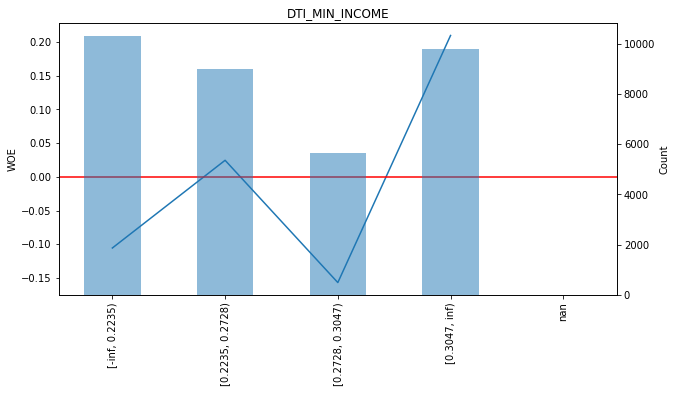

***

### DTI_PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_PRED_INCOME,,,,,,,,
"[-inf, 0.2159)",11564.0,545.0,0.0471,0.3553,0.3317,-0.0673,-0.0687,0.3327
"[0.2159, 0.2818)",12626.0,543.0,0.0430,0.3540,0.3637,0.0266,0.0271,0.3633
"[0.2818, 0.3207)",5384.0,272.0,0.0505,0.1773,0.1539,-0.1389,-0.1418,0.1549
"[0.3207, inf)",5181.0,174.0,0.0336,0.1134,0.1507,0.2773,0.2842,0.1491
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0158
Gini: 6.33


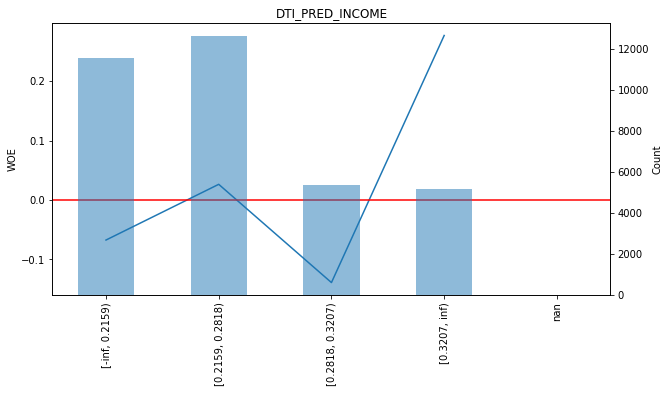

***

### DTI_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_DTI_REPORTED_INCOME,,,,,,,,
"[-inf, 0.1519)",10787.0,563.0,0.0522,0.3670,0.3078,-0.1727,-0.1761,0.3104
"[0.1519, 0.1965)",7716.0,306.0,0.0397,0.1995,0.2231,0.1092,0.1117,0.2220
"[0.1965, 0.2282)",5005.0,260.0,0.0519,0.1695,0.1428,-0.1678,-0.1711,0.1440
"[0.2282, inf)",11247.0,405.0,0.0360,0.2640,0.3264,0.2070,0.2120,0.3236
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0308
Gini: 9.24


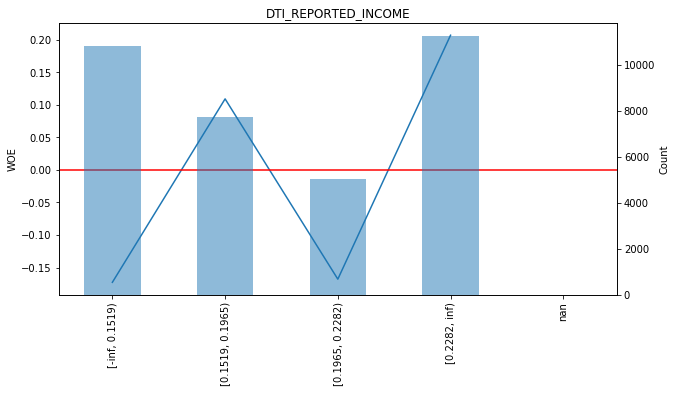

***

### MIN_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_MIN_INCOME,,,,,,,,
"[-inf, 15536.4883)",5227.0,175.0,0.0335,0.1141,0.1521,0.2804,0.2874,0.1504
"[15536.4883, 17246.0195)",5061.0,228.0,0.0451,0.1486,0.1455,-0.0210,-0.0214,0.1456
"[17246.0195, 18795.1611)",6542.0,245.0,0.0375,0.1597,0.1895,0.1673,0.1713,0.1882
"[18795.1611, inf)",17925.0,886.0,0.0494,0.5776,0.5129,-0.1164,-0.1188,0.5158
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0238
Gini: 7.83


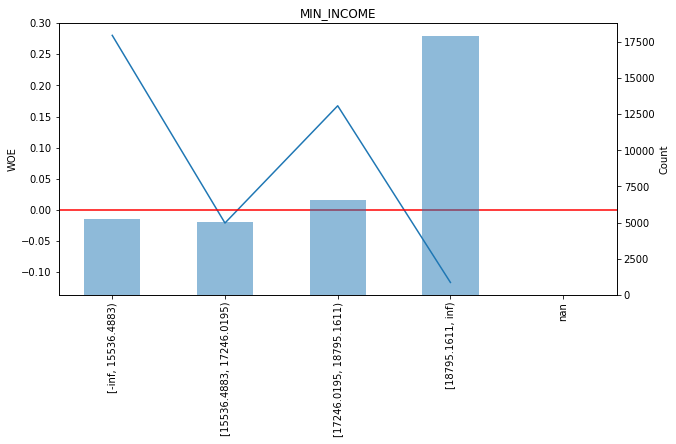

***

### PRED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_PRED_INCOME,,,,,,,,
"[-inf, 17570.0977)",6664.0,275.0,0.0413,0.1793,0.1923,0.0687,0.0703,0.1917
"[17570.0977, 19074.375)",6510.0,238.0,0.0366,0.1552,0.1888,0.1917,0.1963,0.1873
"[19074.375, 20612.4521)",8397.0,421.0,0.0501,0.2744,0.2401,-0.1311,-0.1337,0.2416
"[20612.4521, inf)",13184.0,600.0,0.0455,0.3911,0.3788,-0.0314,-0.0321,0.3793
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0125
Gini: 6.08


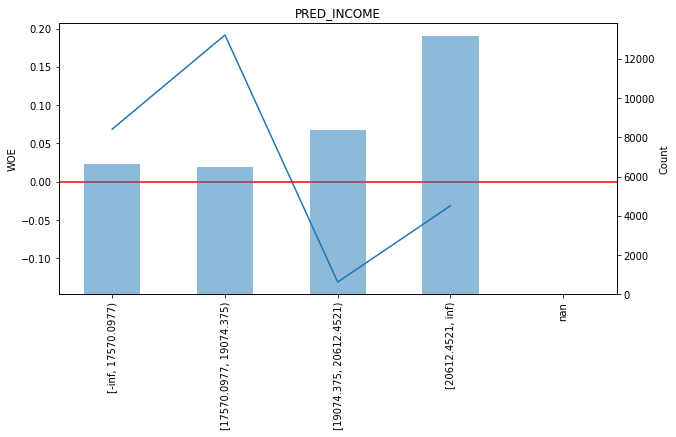

***

### RATIO_PRED_REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_RATIO_PRED_REPORTED_INCOME,,,,,,,,
"[-inf, 0.5662)",8705.0,459.0,0.0527,0.2992,0.2482,-0.1832,-0.1869,0.2505
"[0.5662, 0.8857)",12788.0,532.0,0.0416,0.3468,0.3689,0.0605,0.0618,0.3679
"[0.8857, 1.1486)",7263.0,331.0,0.0456,0.2158,0.2087,-0.0328,-0.0335,0.2090
"[1.1486, inf)",5999.0,212.0,0.0353,0.1382,0.1742,0.2260,0.2315,0.1726
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0195
Gini: 7.64


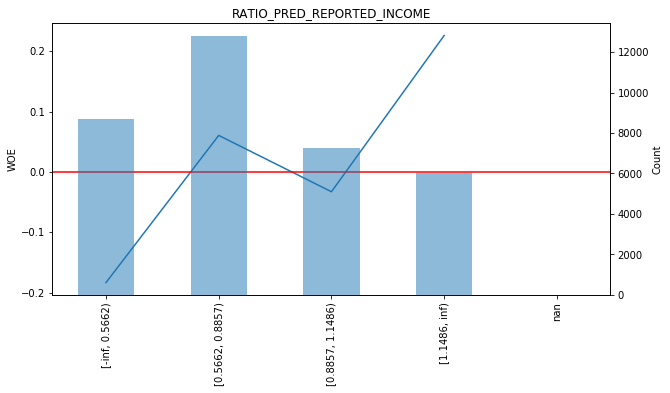

***

### REPORTED_INCOME

,CNT_TOTAL,CNT_DEF,DEF_RATE,DIST_BAD,DIST_GOOD,WOE,WOE_check,SHARE
BIN_REPORTED_INCOME,,,,,,,,
"[-inf, 17999.5)",6276.0,218.0,0.0347,0.1421,0.1824,0.2433,0.2493,0.1806
"[17999.5, 25644.0)",12500.0,555.0,0.0444,0.3618,0.3596,-0.0061,-0.0062,0.3597
"[25644.0, 37973.5)",9020.0,376.0,0.0417,0.2451,0.2602,0.0584,0.0597,0.2595
"[37973.5, inf)",6959.0,385.0,0.0553,0.2510,0.1979,-0.2332,-0.2377,0.2002
nan,0.0,0.0,NaN,0.0000,0.0000,NaN,-3.0753,0.0000


IV: 0.0236
Gini: 8.17


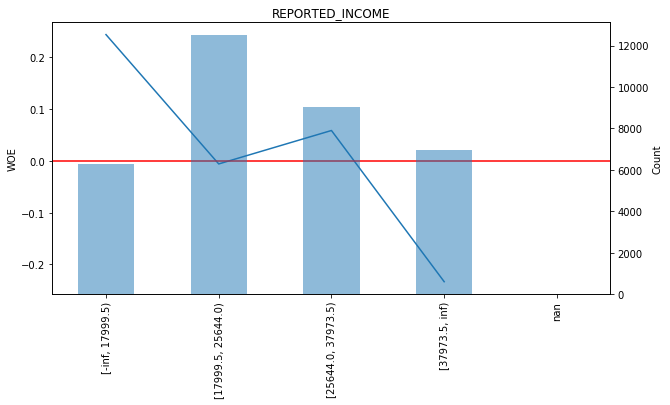

In [115]:
grouping.plot_bins(data=df_train, cols_pred_num=cols_pred_num, cols_pred_cat=cols_pred_cat,
                    mask = pd.Series(df_train["REPORTED_INCOME"]>=0),col_target="RISK_FSTQPD30", 
                   output_folder=r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN", col_weight=None)

In [152]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in df:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
df = df.drop(woe_columns_to_replace, axis='columns')
df = df.join(-data_woe)

print('Added WOE variables. Number of columns:',df.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred_num]

Added WOE variables. Number of columns: 25


# MOM R Square

In [91]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score 

In [92]:
dic= {"MONTH_STR":[],"RMSE":[],"R_SQUARED":[]}
for x in df.MONTH_STR.unique():
    dic["MONTH_STR"].append(x)
    dic["RMSE"].append(round(np.sqrt(mse(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))))
    dic["R_SQUARED"].append(r2_score(df[df.MONTH_STR==x]["REPORTED_INCOME"],df[df.MONTH_STR==x]["PRED_INCOME"]))
    
r_sq_df = pd.DataFrame(dic)

r_sq_df

,MONTH_STR,RMSE,R_SQUARED
0,2019-02,12508.0,-0.362568
1,2019-03,12597.0,-0.474935
2,2019-04,12827.0,-0.478366
3,2019-05,13944.0,-0.638127
4,2019-06,13899.0,-0.589848
5,2019-07,13836.0,-0.580327
6,2019-08,13427.0,-0.508642


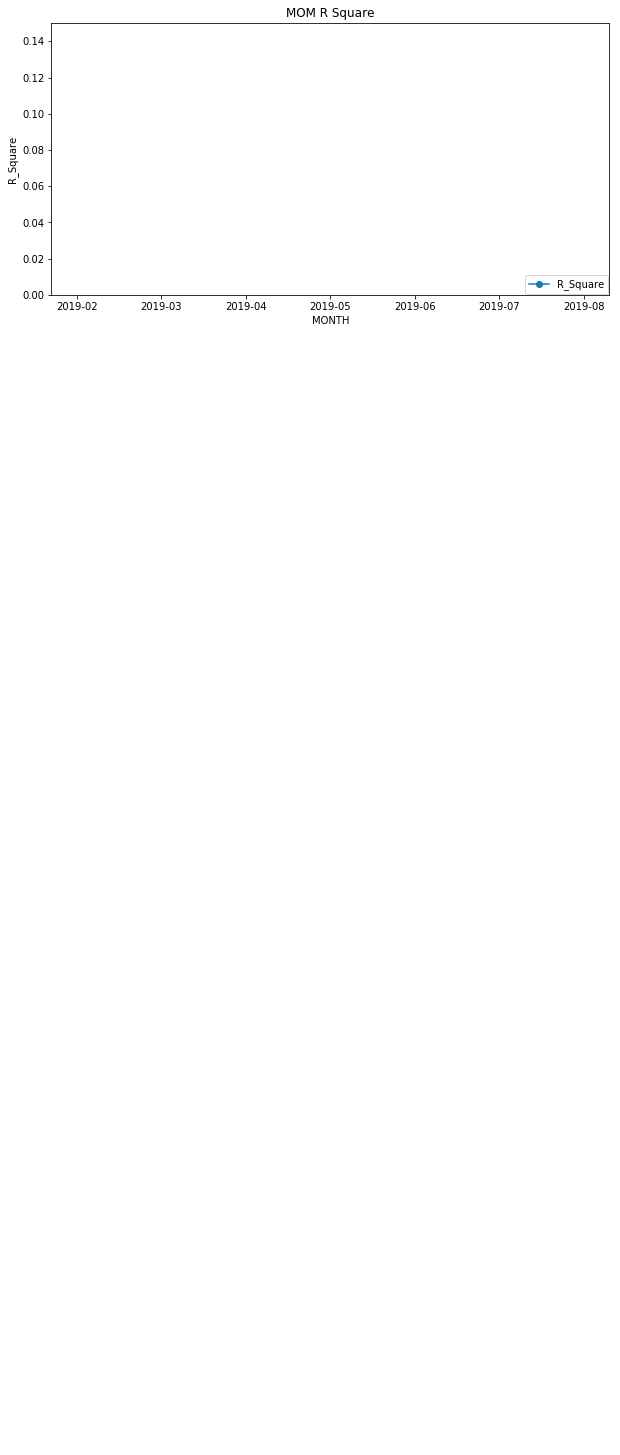

In [93]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(r_sq_df["MONTH_STR"],r_sq_df["R_SQUARED"], marker = 'o', label = 'R_Square')

for i, txt in enumerate(r_sq_df["R_SQUARED"]):
    plt.annotate("{:.2f}".format(txt), (r_sq_df["MONTH_STR"][i], r_sq_df["R_SQUARED"][i]+0.003))

plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,0.15)
plt.ylabel("R_Square")
plt.xlabel("MONTH")
ax1.set_title("MOM R Square")
plt.show()